Tytuł: 
House Prices: Advanced Regression Techniques
Link do konkursu: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview


Cel: Celem jest przewidzenie ceny sprzedaży domów w Ames i Iowa.

1.Sprawdzanie modeli liniowych
Otwieramy nasze datasheety train i test dołączone do projektu
wyświetlenie trainheada

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("~/Pobrane/house/train.csv")
test = pd.read_csv("~/Pobrane/house/test.csv")

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Przygotowywanie danych
Najpierw przekształcamy przekrzywione funkcje numeryczne.
Tworzymy zmienne Dummy dla funkcji jakościowych.
W związku z brakującymi danymi musimy zrobić coś z pustymi polami. Zastępujemy brakujące wartości liczbowe (NaN) średnią ich odpowiednich kolumn.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f468ebaf470>,
      dtype=object)

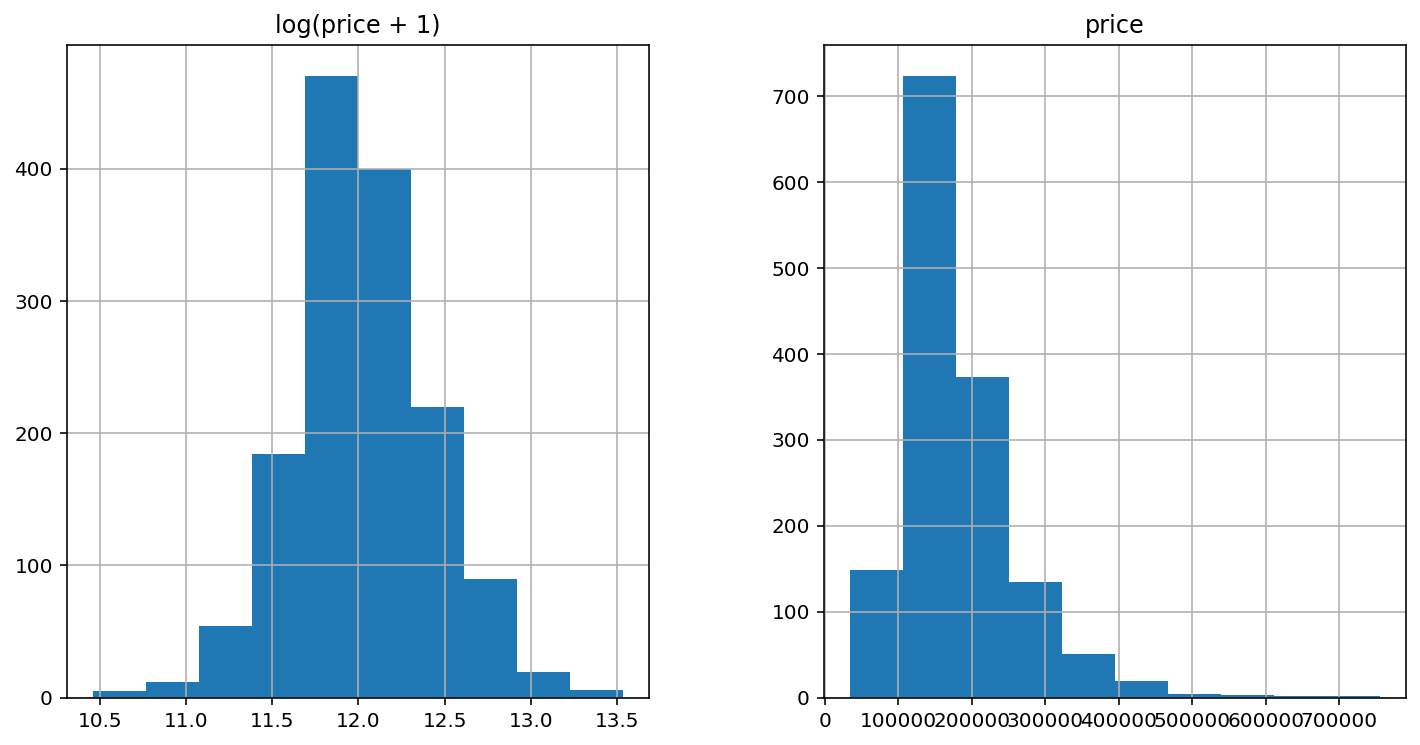

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

/home/misp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log1p
  # This is added back by InteractiveShellApp.init_path()


In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

Przygotowujemy dane do sklearn

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

Teraz będziemy używać regularnych modeli regresji liniowej wykorzystując moduł uczenia scikit. Wypróbujemy zarówno regularyzację Lasso, jak i Ridge. Zdefiniujemy również funkcję, która zwraca błąd rmse weryfikacji krzyżowej, abyśmy mogli ocenić nasze modele i wybrać najlepszy parametr tuningu

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge()

Głównym parametrem dostrajania modelu Ridge'a jest alfa - parametr regularyzacji, który mierzy elastyczność naszego modelu. Im wyższa regularyzacja, tym mniej podatny będzie nasz model na dopasowanie. Utraci to jednak elastyczność i może nie przechwycić całego sygnału w danych.

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]


Text(0, 0.5, 'rmse')

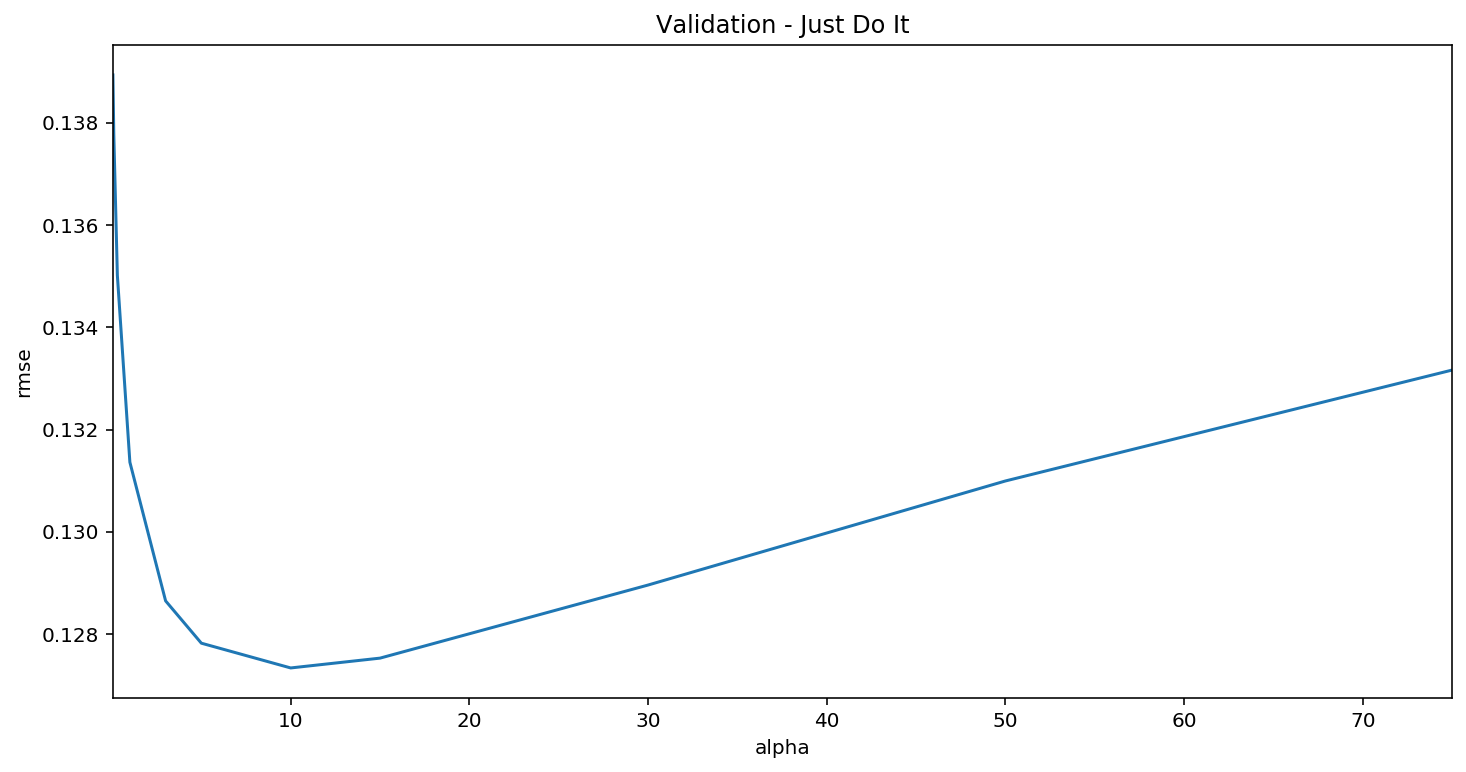

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Gdy alfa jest zbyt duże, regularyzacja jest zbyt silna i model nie może uchwycić wszystkich złożoności danych. Jeśli jednak pozwolimy, aby model był zbyt elastyczny (alfa mały), model zacznie się nadmiernie dopasowywać co jest cechą dla nas nieporządaną.

In [14]:
cv_ridge.min()

0.12733734668670768

Tak więc w przypadku Ridge otrzymujemy wartość około 0.12733734668670768.

Teraz wypróbujemy model Lasso. Zastosujemy tutaj inne podejście i wykorzystamy wbudowane CV Lasso, aby znaleźć najlepszą dla nas alfę.

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/home/misp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [16]:
rmse_cv(model_lasso).mean()

/home/misp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/misp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/misp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/misp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

0.12314421090977432

Lasso działa lepiej, więc użyjemy tego modelu na zestawie testowym. Ciekawą funkcją Lasso jest to, że dokonuje wyboru funkcji - ustawiając współczynniki cech, które uważa za nieistotne na zero. Spójrzmy na współczynniki:

In [17]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Należy jednak zauważyć, że wybrane funkcje niekoniecznie są „prawidłowe” - zwłaszcza, że w tym zestawie danych jest wiele cech współliniowych. Jednym z pomysłów do wypróbowania tutaj jest kilkakrotne uruchomienie Lasso z przyspieszoną próbką i sprawdzenie, jak stabilny jest wybór funkcji.

Możemy również zwrócić uwagę na najważniejsze współczynniki:

In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

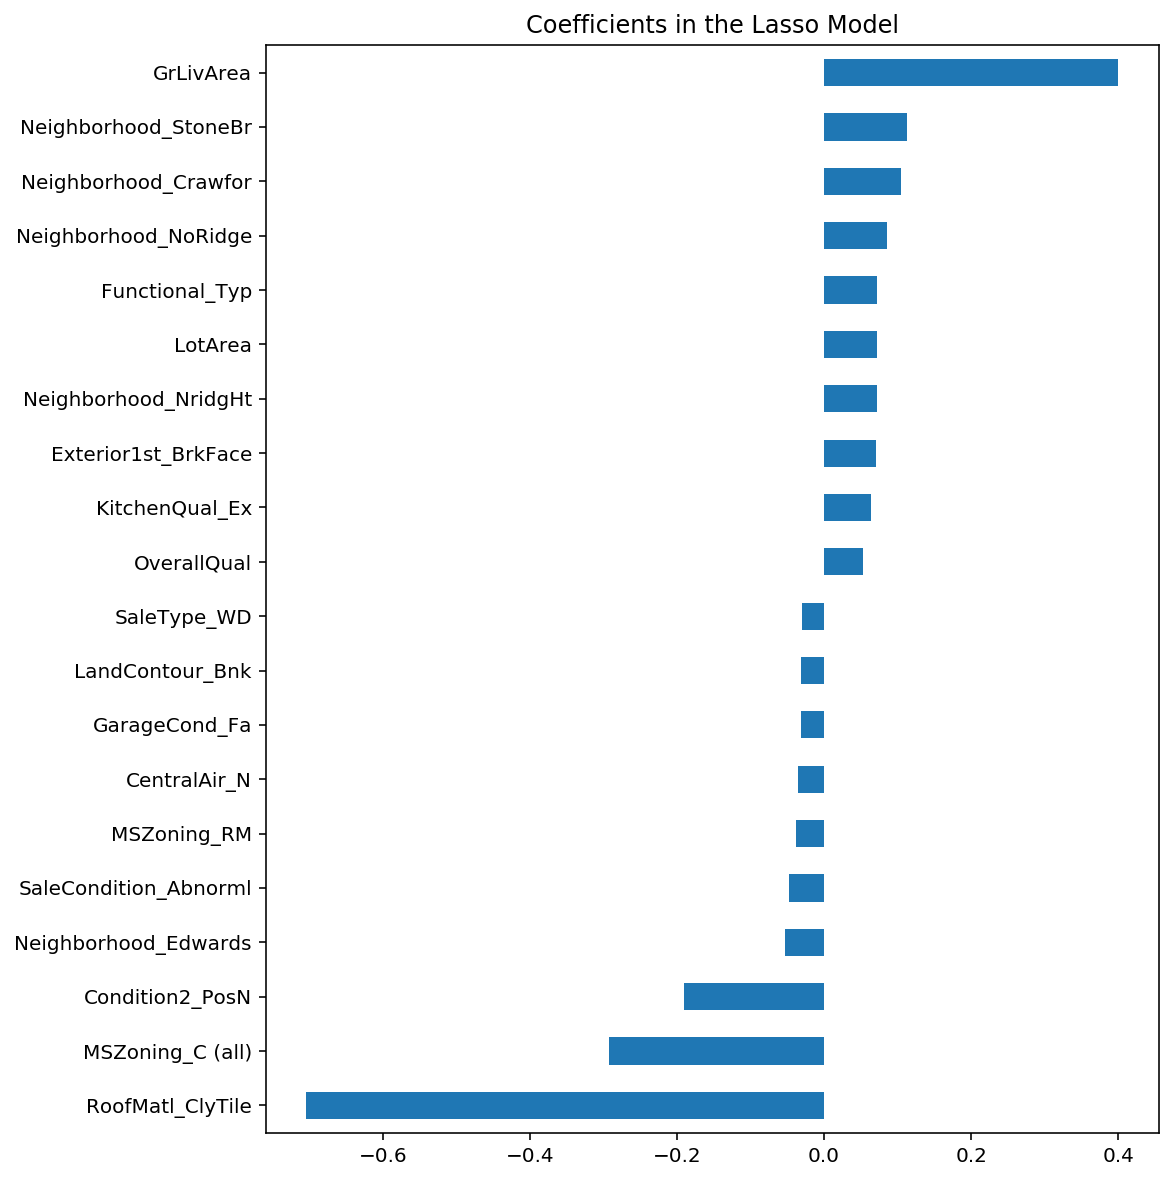

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Najważniejszą pozytywną cechą jest GrLivArea - a więc prawdopodobnie w tłumaczeniu na polski powierzchnia działki. To zdecydowanie ma sens. Następnie kilka innych funkcji związanych z lokalizacją i jakością miało również pozytywny wpływ. Niektóre negatywne cechy mają mniej sensu i warto byłoby przyjrzeć się im nieco bardziej.

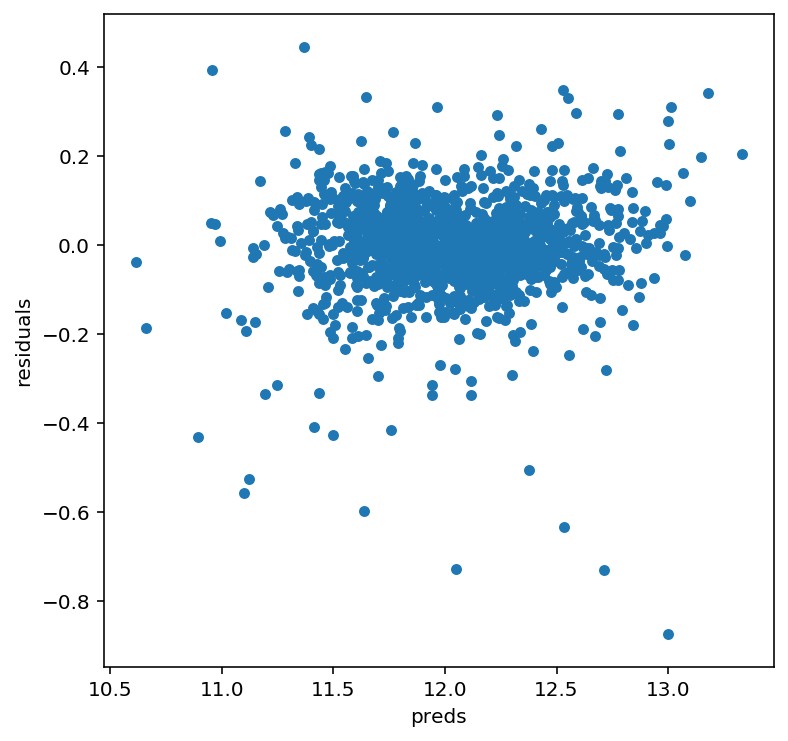

In [21]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Wykres wygląda dobrze, ale sprawdzimy jeszcze metodę z modelem xgboost tak jak sugerwane to było na zajęciach. 


2.Dodajemy więc model xgboost do naszego modelu liniowego, aby zobaczyć, czy możemy poprawić nasz wynik:

In [22]:
import xgboost as xgb

In [23]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

/home/misp/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/misp/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


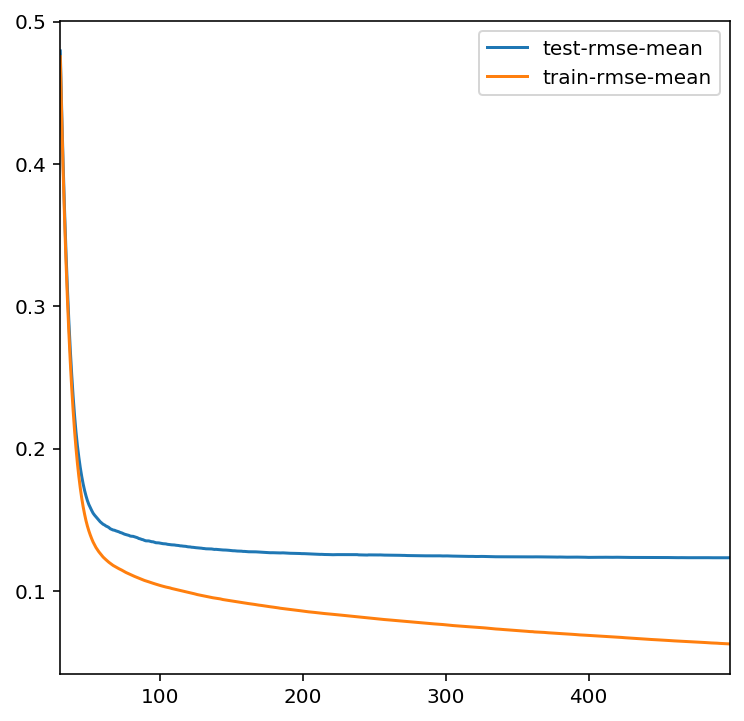

In [24]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

[17:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

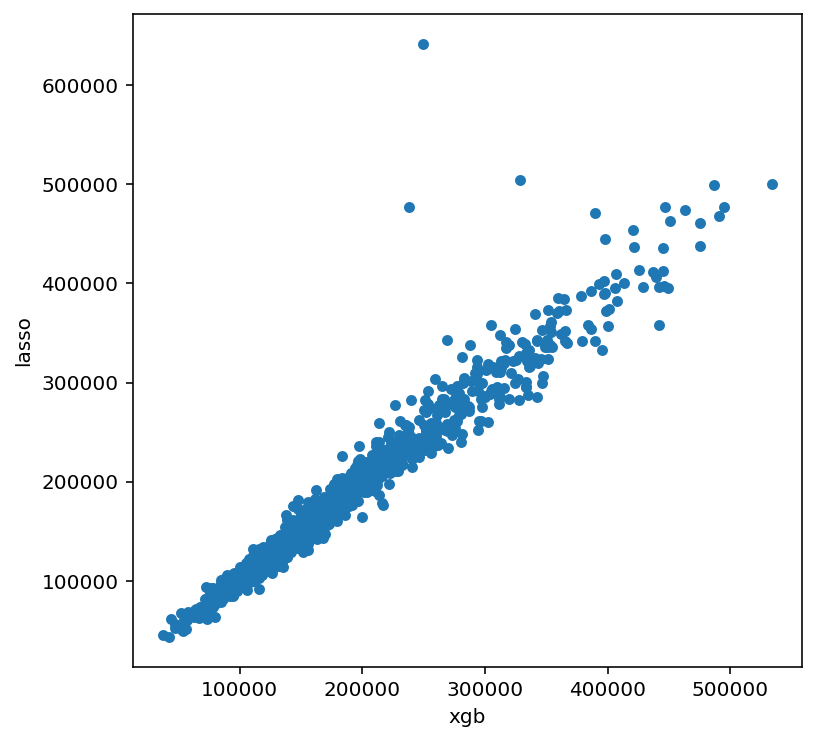

In [27]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Zwykle sensowne jest przyjmowanie średniej ważonej nieskorelowanych wyników - często poprawia to wyniki, chociaż w tym przypadku nie zauważyliśmy znacznej poprawy. 

In [28]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

Wyniki zapisujemy w pliku nowe_nasze.csv i publikujemy na stronie. Dołączony zostanie również zrzut ekranu z naszym wynikiem z wykorzystaniem modelu xgboost(0.12086). Użycie modelu xgboost znacznie poprawiło nasz wynik końcowy w porównaniu do metod  liniowych.

In [31]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("nowe_nasze.csv", index = False)